In [431]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

import statsmodels.api as sm
from sklearn.cross_validation import train_test_split

In [432]:
# Load data:
master = pd.read_csv("./oh_ds_challenge.csv")

### Helper functions for pre-processing data and feature engineering:

In [433]:
def remove_improbable_losses(df, threshold=0.4):
    """
    Remove participants whose week16_loss > threshold

    INPUT: df (pandas dataframe)
    OUTPUT: df, filtered
    """
    outliers = df[df['week16_loss'] > threshold]['id'].unique()
    return df[~df['id'].isin(outliers)]


def add_gender_dummy(df):
    """
    Add a binary (0,1) column for "gender" and drop original
    1 for female, 0 for male
    """
    df['is_female'] = pd.get_dummies(df['gender'])['f']
    return df.drop('gender', axis=1)


def remove_missing_target(df):
    """
    Remove participants who have not finished the program
    (i.e.) week16_loss, aka our target, is missing
    
    One could also count rows per person, or look max
    program_week, depending on data integrity issues
    """
    return df[~df['week16_loss'].isnull()]


def add_engagement(df):
    """
    Combine engagement scores per row into new weekly metric
    """
    df['engagement_score'] = df['n_activities_tracked'] + df['n_group_comments'] + \
        df['n_group_messages'] + df['n_lessons'] + df['n_log_ins'] + \
        df['n_meals_tracked'] + df['n_private_messages']
    return df


def add_total_engagement(df):
    """
    Aggregate weekly metric per person
    """
    df['total_engagement'] = df['engagement_score'].groupby(df['id']).transform('sum')
    return df

In [571]:
# Preparing our data
df = remove_missing_target(master) # focusing only on those who finished all 16 weeks
df = remove_improbable_losses(df) # remove outliers
df = add_gender_dummy(df) # add binary 'is_female' column
df = add_engagement(df) # combine engagement scores
df = add_total_engagement(df) # tally engagement scores per person

# select features to use for model
predictors = ['initial_weight', 'age', 'is_female', 'bmi', \
 'personality_extraverted', 'personality_conventional', 'readiness_change_food', \
 'readiness_change_phys', 'n_weigh_ins', 'n_lessons', \
 'n_private_messages', 'n_group_messages', 'n_group_comments', \
 'n_log_ins', 'n_meals_tracked', 'n_activities_tracked']

# select target
target = 'week16_loss'

# select only one row per person to train on (last row should do)
model_ready = df[df['program_week']==16]

X = model_ready[predictors]
y = model_ready[target]

# create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Let's try a simple linear regression first

In [572]:
ols_model1 = sm.OLS(y_train, exog=X_train)
ols_results1 = ols_model1.fit()
ols_results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            week16_loss   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     96.37
Date:                Sat, 05 Mar 2016   Prob (F-statistic):          9.70e-190
Time:                        12:01:33   Log-Likelihood:                 1856.2
No. Observations:                1018   AIC:                            -3680.
Df Residuals:                    1002   BIC:                            -3602.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
initial_weight            9.087e-05   6.36e-05      1.428      0.154      -3.4e-05     0.000
age                          0.0003   9.08e-05      3.684      0.000         0.000     0.001
is_female                   -0.0039      0.004     -1.072      0.284        -0.011     0.003
bmi                         -0.0003      0.000     -0.754      0.451        -0.001     0.001
personality_extraverted     -0.0004      0.000     -0.857      0.392        -0.001     0.000
personality_conventional     0.0008      0.001      1.338      0.181        -0.000     0.002
readiness_change_food       -0.0017      0.001     -1.958      0.051        -0.003  3.85e-06
readiness_change_phys        0.0017      0.001      2.195      0.028         0.000     0.003
n_weigh_ins                  0.0032      0.000      7.597      0.000         0.002     0.004
n_lessons                    0.0028      0.001      2.066      0.039         0.000     0.005
n_private_messages          -0.0014      0.002     -0.745      0.456        -0.005     0.002
n_group_messages             0.0084      0.004      2.249      0.025         0.001     0.016
n_group_comments             0.0024      0.001      2.664      0.008         0.001     0.004
n_log_ins                    0.0008      0.000      2.589      0.010         0.000     0.001
n_meals_tracked              0.0020      0.001      2.532      0.012         0.000     0.004
n_activities_tracked         0.0007      0.001      0.949      0.343        -0.001     0.002
==============================================================================
Omnibus:                      148.311   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              341.661
Skew:                           0.812   Prob(JB):                     6.45e-75
Kurtosis:                       5.328   Cond. No.                         683.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Not a *terrible* R^2 score at 0.624. There are some predictors with high p_values that we can likely do without to get a more generalizable model less prone to varying with noise.   Furthermore, intuitively we can guess many of these variables are highly correlated. 

But first, **let's see how we do on the test set** (target/label are still known)

In [624]:
def get_mean_abs_error(model, X_test, y_test):
    preds = model.predict(X_test)
    err = sum(abs(y_test - preds)) / len(y_test)
    return err

In [621]:
get_mean_abs_error(ols_results1, X_test, y_test)

0.027665883473366612

I'm using mean absolute error here because it is more interpretable than mean-squared error.
Our model is, on average, 2.7% off. Which isn't great, but also not terrible.
Let's now try trimming down the variables and see if we can still keep the same error

In [625]:
important_predictors = results.pvalues[results.pvalues < 0.05].index

ols_model2 = OLS(y_train, X_train[important_predictors])
ols_results2 = ols_model2.fit()

ols_results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            week16_loss   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     187.2
Date:                Sat, 05 Mar 2016   Prob (F-statistic):          1.73e-193
Time:                        12:36:55   Log-Likelihood:                 1844.8
No. Observations:                1018   AIC:                            -3674.
Df Residuals:                    1010   BIC:                            -3634.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
age                       0.0003   8.16e-05      3.927      0.000         0.000     0.000
readiness_change_phys     0.0005      0.000      0.999      0.318        -0.000     0.001
n_weigh_ins               0.0032      0.000      7.623      0.000         0.002     0.004
n_lessons                 0.0023      0.001      1.746      0.081        -0.000     0.005
n_group_comments          0.0021      0.001      2.367      0.018         0.000     0.004
n_log_ins                 0.0010      0.000      3.036      0.002         0.000     0.002
n_meals_tracked           0.0020      0.001      2.481      0.013         0.000     0.004
n_activities_tracked      0.0009      0.001      1.264      0.207        -0.000     0.002
==============================================================================
Omnibus:                      143.425   Durbin-Watson:                   2.109
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              328.538
Skew:                           0.790   Prob(JB):                     4.56e-72
Kurtosis:                       5.291   Cond. No.                         55.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### For using only half as many predictors (8 rather than 16), the reduction in R^2 is ok.
We can also note that p_values that were small in previous model are now larger. This indicates colinearity among the variables, as we guessed. This could mean that test scores haven't changed much with this new model. Let's try it out!

In [626]:
get_mean_abs_error(ols_results2, X_test[important_predictors], y_test)

0.027676522815333466

Test error is basically the same with much fewer features, so it makes sense to keep the simpler model. It would be interesting to perform PCA on features we suspect are co-linear to reduce dimensionality, using the optimal linear transformation of them to use in our regression model as a sort of super-variable. We should note that while doing so may improve the model's predictive power, the super-variable will likely not have an intuitive interpretation.

## Another way to deal with colinearity is using a decision tree method. 

In [627]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train,y_train)

print("Error:")
get_mean_abs_error(rf, X_test, y_test)

Error:


0.028551239925667011

Comparable error on the test set! 

# The good stuff: Feature importances
Now we can see which features our ensemble has figured out to be most salient in splitting up the data, regardless of colinearity among the parameters. We do know from OLS that all engagement is positively correlated with outcomes, so feature importances can be interpreted in that light.

<Container object of 16 artists>

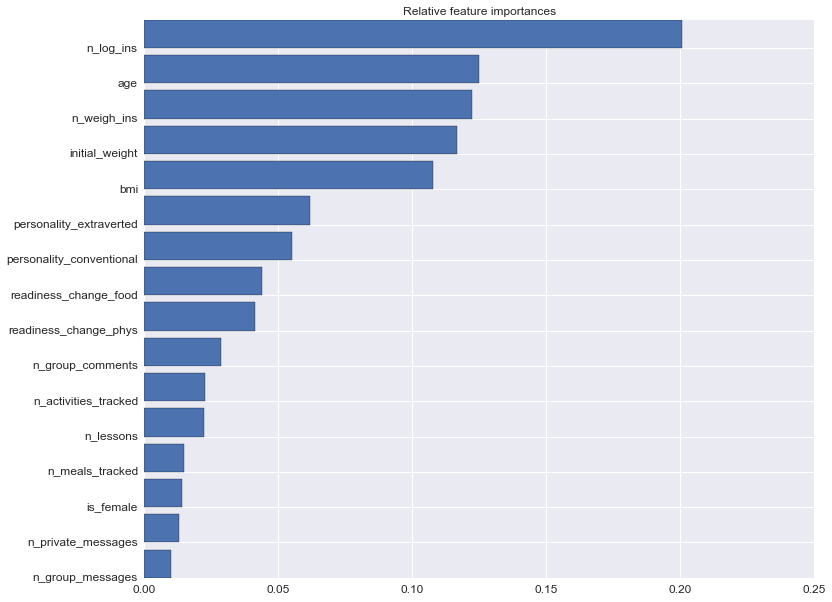

In [581]:
# Features, sorted by importance:
rf_feats = zip(rf.feature_importances_, predictors)
rf_feats_sorted = sorted(rf_feats, key=lambda t: t[0])

# Prepare to plot!
x_vals = range(len(rf_feats_sorted))
y_vals = [val for val,name in rf_feats_sorted]
y_ticks = [name for val,name in rf_feats_sorted]
fig = plt.figure(figsize=(12,10))
plt.title("Relative feature importances")
plt.tick_params(labelsize='large')
plt.yticks(x_vals, y_ticks)
plt.barh(bottom=x_vals,width=y_vals)

# Finally, let's predict weight loss for those who haven't finished the program

In [603]:
def get_new_users(masterdf):
    temp = master.groupby('id').max()
    new_users = temp[temp['program_week'] < 16]
    new_users = add_gender_dummy(new_users)
    return new_users

In [604]:
new_users = get_new_users(master)

/Applications/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [608]:
prediction = rf.predict(new_users[predictors])

<Container object of 336 artists>

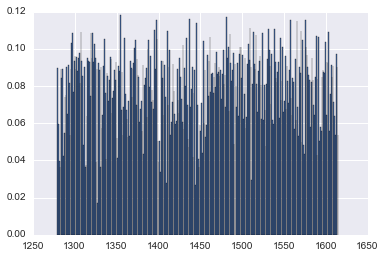

In [609]:
plt.bar(new_users.index, prediction)